In [1]:
##############################################################################
#                                                                            #
#  Code for the USENIX Security '22 paper:                                   #
#  How Machine Learning Is Solving the Binary Function Similarity Problem.   #
#                                                                            #
#  MIT License                                                               #
#                                                                            #
#  Copyright (c) 2019-2022 Cisco Talos                                       #
#                                                                            #
#  Permission is hereby granted, free of charge, to any person obtaining     #
#  a copy of this software and associated documentation files (the           #
#  "Software"), to deal in the Software without restriction, including       #
#  without limitation the rights to use, copy, modify, merge, publish,       #
#  distribute, sublicense, and/or sell copies of the Software, and to        #
#  permit persons to whom the Software is furnished to do so, subject to     #
#  the following conditions:                                                 #
#                                                                            #
#  The above copyright notice and this permission notice shall be            #
#  included in all copies or substantial portions of the Software.           #
#                                                                            #
#  THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,           #
#  EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF        #
#  MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND                     #
#  NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE    #
#  LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION    #
#  OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION     #
#  WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.           #
#                                                                            #
#  MRR@10 and Recall@K                                                       #
#                                                                            #
##############################################################################

In [2]:
import json
import math
import numpy as np
import os
import pandas as pd
import scipy.stats as stats

from IPython.display import display
from collections import defaultdict
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

### Utility functions

In [3]:
def merge_data(df_pairs, df_similarity):
    df_pairs = df_pairs.merge(
        df_similarity,
        how='left',
        left_on=['idb_path_1', 'fva_1', 'idb_path_2', 'fva_2'],
        right_on=['idb_path_1', 'fva_1', 'idb_path_2', 'fva_2'])
    return df_pairs

In [4]:
def compute_ranking(df_pos, df_neg, test_name, r_dict, rank_method):
    TH_LIST = [1] + list(range(5, 55, 5))

    for task in sorted(set(df_pos['db_type'])):
        df_pos_task = df_pos[df_pos['db_type'] == task]
        df_neg_task = df_neg[df_neg['db_type'] == task]

        tot_pos = df_pos_task.shape[0]

        # Compute the ranking for all the positive test cases
        rank_list = list()
        for idx, group in df_neg_task.groupby(['idb_path_1', 'fva_1']):
            c1 = (df_pos_task['idb_path_1'] == idx[0])
            c2 = (df_pos_task['fva_1'] == idx[1])
            pos_pred = df_pos_task[c1 & c2]['sim'].values[0]
            neg_pred = list(group['sim'].values)
            assert(len(neg_pred) == 100)
            ranks = stats.rankdata([pos_pred] + neg_pred, method=rank_method)
            rank_list.append(102 - ranks[0])

        # Compute the ranking list
        cc_list = list()
        for th in TH_LIST:
            cc_list.append(len([x for x in rank_list if x <= th]))

        # MRR@10 metric
        tmp_list = [1 / x if x <= 10 else 0 for x in rank_list]
        MRR = sum(tmp_list) / len(tmp_list)

        # Save data in a temporary dictionary
        if task not in r_dict:
            r_dict[task] = defaultdict(list)

        r_dict[task]['model_name'].append(test_name)
        for th, cc in zip(TH_LIST, cc_list):
            r_dict[task]["Recall@{}".format(th)].append(cc / tot_pos)
        r_dict[task]["MRR@10"].append(MRR)

In [5]:
def from_dict_to_df_and_plot(r_dict, output_dir, rank_method):
    markers_pool = list()
    for item in mpl.markers.MarkerStyle.markers.items():
        if item[1] != 'nothing' and \
                not item[1].startswith('tick') and \
                not item[1].startswith('caret'):
            markers_pool.append(item[1])
    markers = np.random.choice(markers_pool, 10, replace=False)

    for task in r_dict.keys():
        print("[D] Task: {}".format(task))
        df_rank = pd.DataFrame.from_dict(r_dict[task])
        df_rank.set_index('model_name', inplace=True)
        csv_name = "df_MRR@10_Recall@K_{}_{}.csv".format(task, rank_method)
        df_rank.to_csv(os.path.join(output_dir, csv_name))

        cols = ['Recall@{}'.format(x) for x in range(5, 55, 5)]
        df_rank = df_rank[cols]
        df_rank.columns = range(5, 55, 5)
        df_rank = df_rank.transpose()

        columns_list = [
            "catalog1_16",
            "catalog1_32",
            "catalog1_64",
            "GGSNN_NoFeatures_e10",
            "GMN_NoFeatures_e16",
            "GNN-s2v_AttentionMean_e5",
            "GNN-s2v_GeminiNN_NoFeatures_e5",
            "GNN-s2v_RNN_ASM_e7",
            "IMM:0.00_MNEM:0.00_GRAPH:1.00",
            "IMM:1.00_MNEM:1.00_GRAPH:1.00",
            "IMM:4.00_MNEM:0.05_GRAPH:1.00",
            "SAFE_ASM-list_250_e5",
            "SAFE_ASM-list_e5",
            "SAFE_ASM-list_Rand_Trainable_e10",
        ]
        
        # Rename the columns to be consistent with the nomenclature in the paper.
        df_rank.rename(
            columns={
                "asm2vec_e10": "Asm2Vec",
                "catalog1_128": "Catalog1: size 128",
                "IMM:0.00_MNEM:1.00_GRAPH:1.00": "FSS: G+M",
                "GMN_OPC-200_e16": "GMN (direct comparison): CFG + BoW opc 200",
                "GNN-s2v_GeminiNN_OPC-200_e5": "GNN (s2v): CFG + BoW opc 200",
                "GNN-s2v_GeminiNN_GeminiFeatures_e5": "GNN (s2v): CFG + Gemini",
                "GGSNN_OPC-200_e10": "GNN: CFG + BoW opc 200",
                "pvdbow_e10": "PV-DBOW",
                "pvdm_e10": "PV-DM",
                "Trex": "TREX",
                "GNN-s2v_ArithMean_e5": "w2v + AVG + GNN (s2v)",
                "SAFE_ASM-list_Trainable_e10": "w2v + SAFE + trainable",
                "Zeek": "Zeek",
            },
            inplace=True,
        )

        # Plot only the "most significant" tests
        for col in columns_list:
            if col in df_rank.columns:
                del df_rank[col]

        ax = df_rank.plot(
            logy=False,
            style='--',
            marker='d',
            ylim=(0, 1),
            figsize=(10, 10))

        ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

        ax.set_aspect(aspect=40)
        ax.set_xlabel("K: number of results.")
        ax.set_ylabel("Recall@K")
        ax.set_title("Task: {}".format(task))
        plt.savefig(os.path.join(
            output_dir, "Recall@K_{}_{}.png".format(task, rank_method)), dpi=300)

In [6]:
def compute_mrr_and_recall(df_pos, df_neg, results_dir, output_dir):
    # Alternatives: min or max
    rank_method = 'min'
    print("[D] Using rank_method: {}".format(rank_method))
    results_dict = dict()
    for csv_file in sorted(os.listdir(results_dir)):
        if (not csv_file.endswith(".csv")) or \
                ("pos_rank_testing" not in csv_file):
            continue

        print("[D] Processing\n\t{}\n\t{}".format(
            csv_file, csv_file.replace("pos_testing", "neg_testing")))

        df_pos_sim = pd.read_csv(
            os.path.join(results_dir, csv_file))

        df_neg_sim = pd.read_csv(
            os.path.join(results_dir, csv_file.replace(
                "pos_rank_testing", "neg_rank_testing")))

        assert(df_pos_sim.isna().sum()['sim'] == 0)
        assert(df_neg_sim.isna().sum()['sim'] == 0)

        df_pos_m = merge_data(df_pos, df_pos_sim)
        df_neg_m = merge_data(df_neg, df_neg_sim)

        test_name = csv_file.replace("pos_rank_testing_", "")
        test_name = test_name.replace("Dataset-1_", "")
        test_name = test_name.replace("Dataset-2-CodeCMR_", "")
        test_name = test_name.replace("Dataset-2_", "")
        test_name = test_name.replace(".csv", "")
        compute_ranking(df_pos_m, df_neg_m, test_name,
                        results_dict, rank_method=rank_method)

    from_dict_to_df_and_plot(results_dict, output_dir, rank_method)

In [7]:
df_sim = pd.read_csv("../data/Dataset-1/pos_testing_Dataset-1_GGSNN_NoFeatures_e10.csv", index_col=0)

In [8]:
df_sim.head()

,fva_1,idb_path_2,fva_2,sim
idb_path_1,,,,
IDBs/Dataset-1/z3/x64-clang-9-O1_z3.i64,0xa2cb80,IDBs/Dataset-1/z3/x64-gcc-4.8-O1_z3.i64,0xc60c60,-2.105312
IDBs/Dataset-1/z3/arm64-gcc-7-O2_z3.i64,0x9fde10,IDBs/Dataset-1/z3/arm64-clang-9-O2_z3.i64,0x99a264,-1.851577
IDBs/Dataset-1/z3/x64-clang-3.5-O1_z3.i64,0x80d6a0,IDBs/Dataset-1/z3/x64-gcc-4.8-O1_z3.i64,0x98bf9a,-0.830177
IDBs/Dataset-1/z3/arm32-clang-9-O0_z3.i64,0xc11700,IDBs/Dataset-1/z3/arm32-gcc-7-O0_z3.i64,0xaee38c,-0.956706
IDBs/Dataset-1/nmap/arm64-clang-9-O1_nping.i64,0x28ebb0,IDBs/Dataset-1/nmap/arm64-gcc-7-O1_nping.i64,0x658d4,-5.482278


In [9]:
# Create output folders
!mkdir -p metrics_and_plots/Dataset-1
!mkdir -p metrics_and_plots/Dataset-1-CodeCMR
!mkdir -p metrics_and_plots/Dataset-2

## Dataset 1

[D] Using rank_method: min
[D] Processing
	pos_rank_testing_Dataset-1_GGSNN_NoFeatures_e10.csv
	pos_rank_testing_Dataset-1_GGSNN_NoFeatures_e10.csv
[D] Processing
	pos_rank_testing_Dataset-1_GGSNN_OPC-200_e10.csv
	pos_rank_testing_Dataset-1_GGSNN_OPC-200_e10.csv
[D] Processing
	pos_rank_testing_Dataset-1_GMN_NoFeatures_e16.csv
	pos_rank_testing_Dataset-1_GMN_NoFeatures_e16.csv
[D] Processing
	pos_rank_testing_Dataset-1_GMN_OPC-200_e16.csv
	pos_rank_testing_Dataset-1_GMN_OPC-200_e16.csv
[D] Processing
	pos_rank_testing_Dataset-1_GNN-s2v_ArithMean_e5.csv
	pos_rank_testing_Dataset-1_GNN-s2v_ArithMean_e5.csv
[D] Processing
	pos_rank_testing_Dataset-1_GNN-s2v_AttentionMean_e5.csv
	pos_rank_testing_Dataset-1_GNN-s2v_AttentionMean_e5.csv
[D] Processing
	pos_rank_testing_Dataset-1_GNN-s2v_GeminiNN_GeminiFeatures_e5.csv
	pos_rank_testing_Dataset-1_GNN-s2v_GeminiNN_GeminiFeatures_e5.csv
[D] Processing
	pos_rank_testing_Dataset-1_GNN-s2v_GeminiNN_NoFeatures_e5.csv
	pos_rank_testing_Dataset-1_GNN-

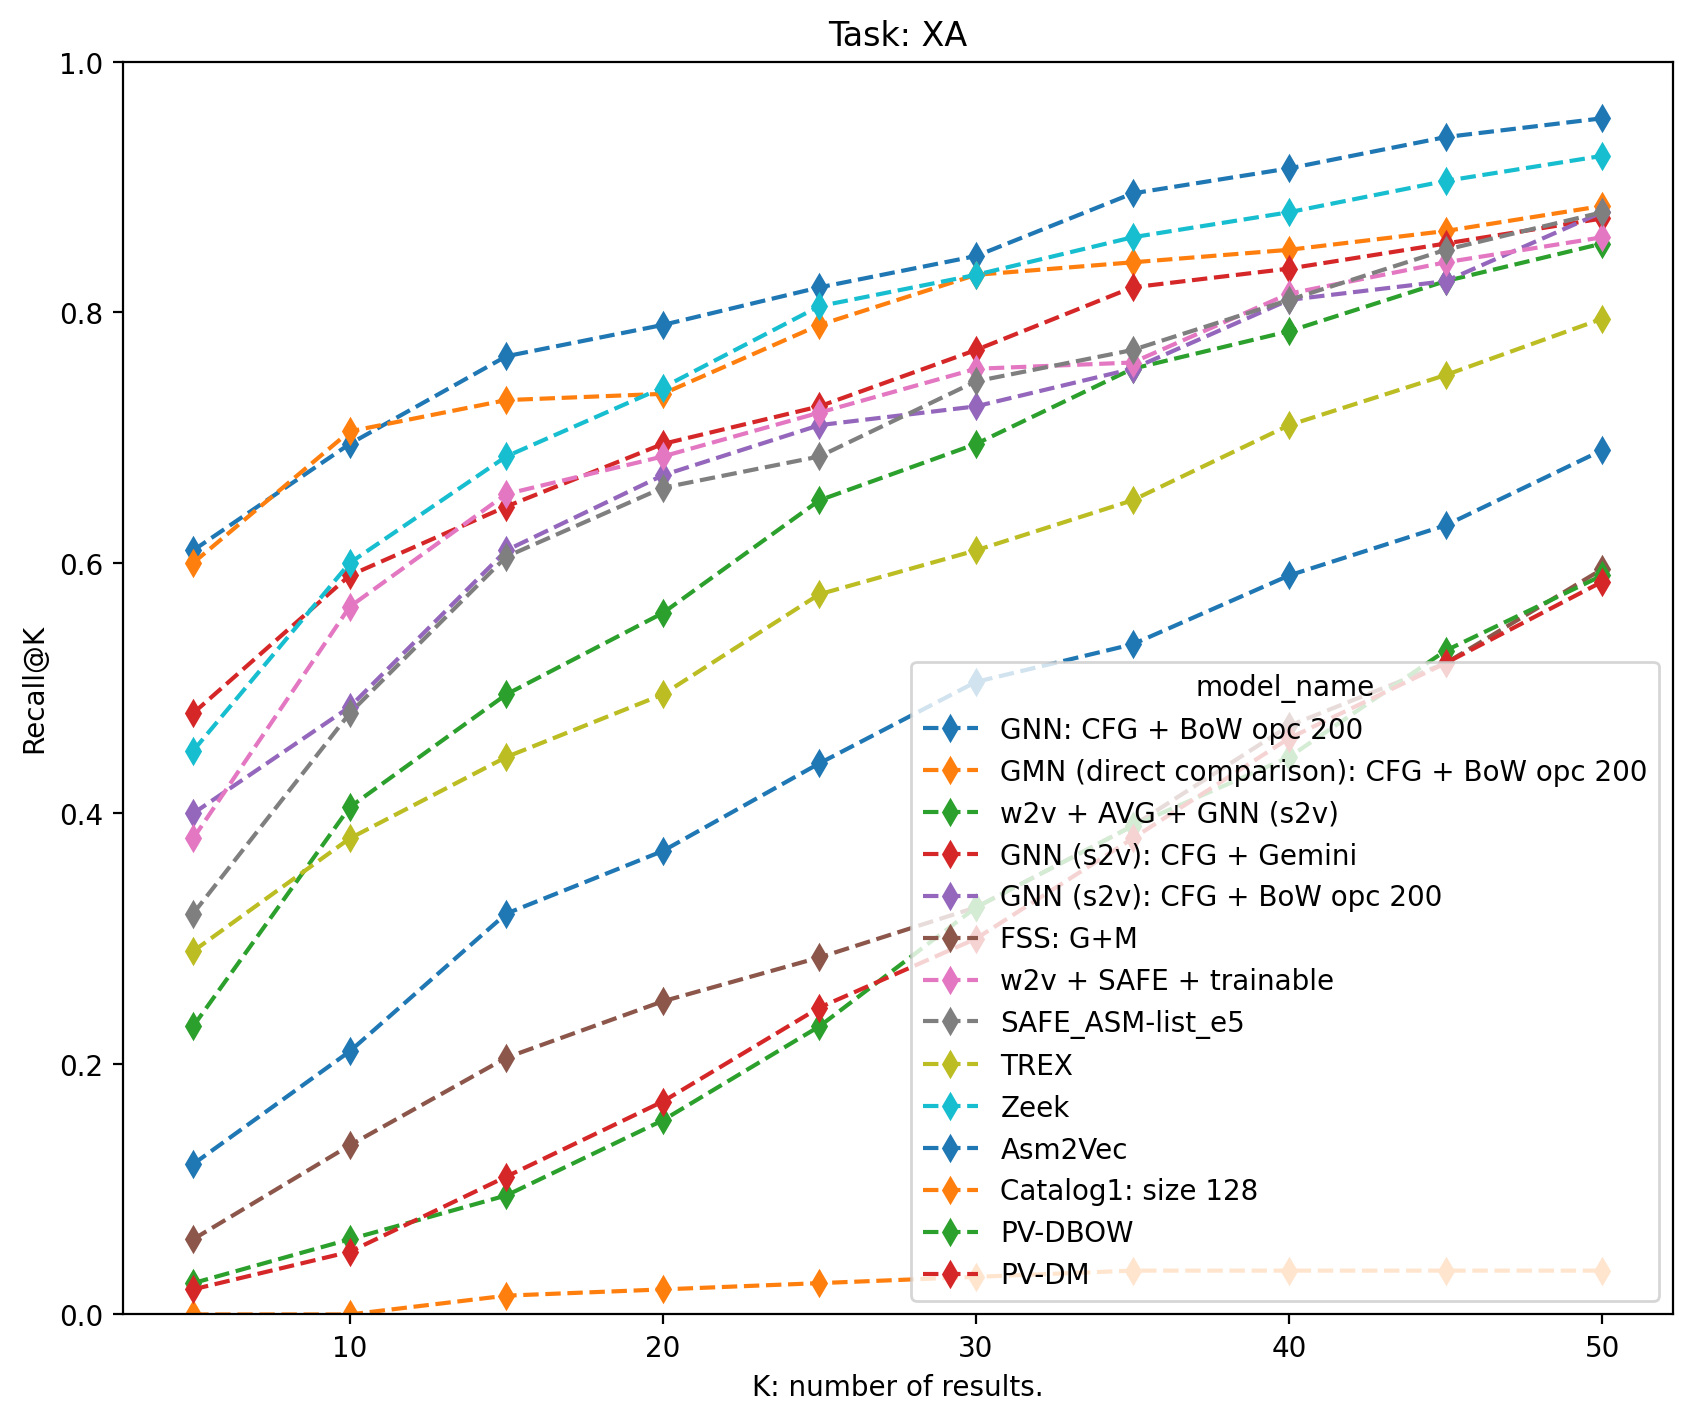

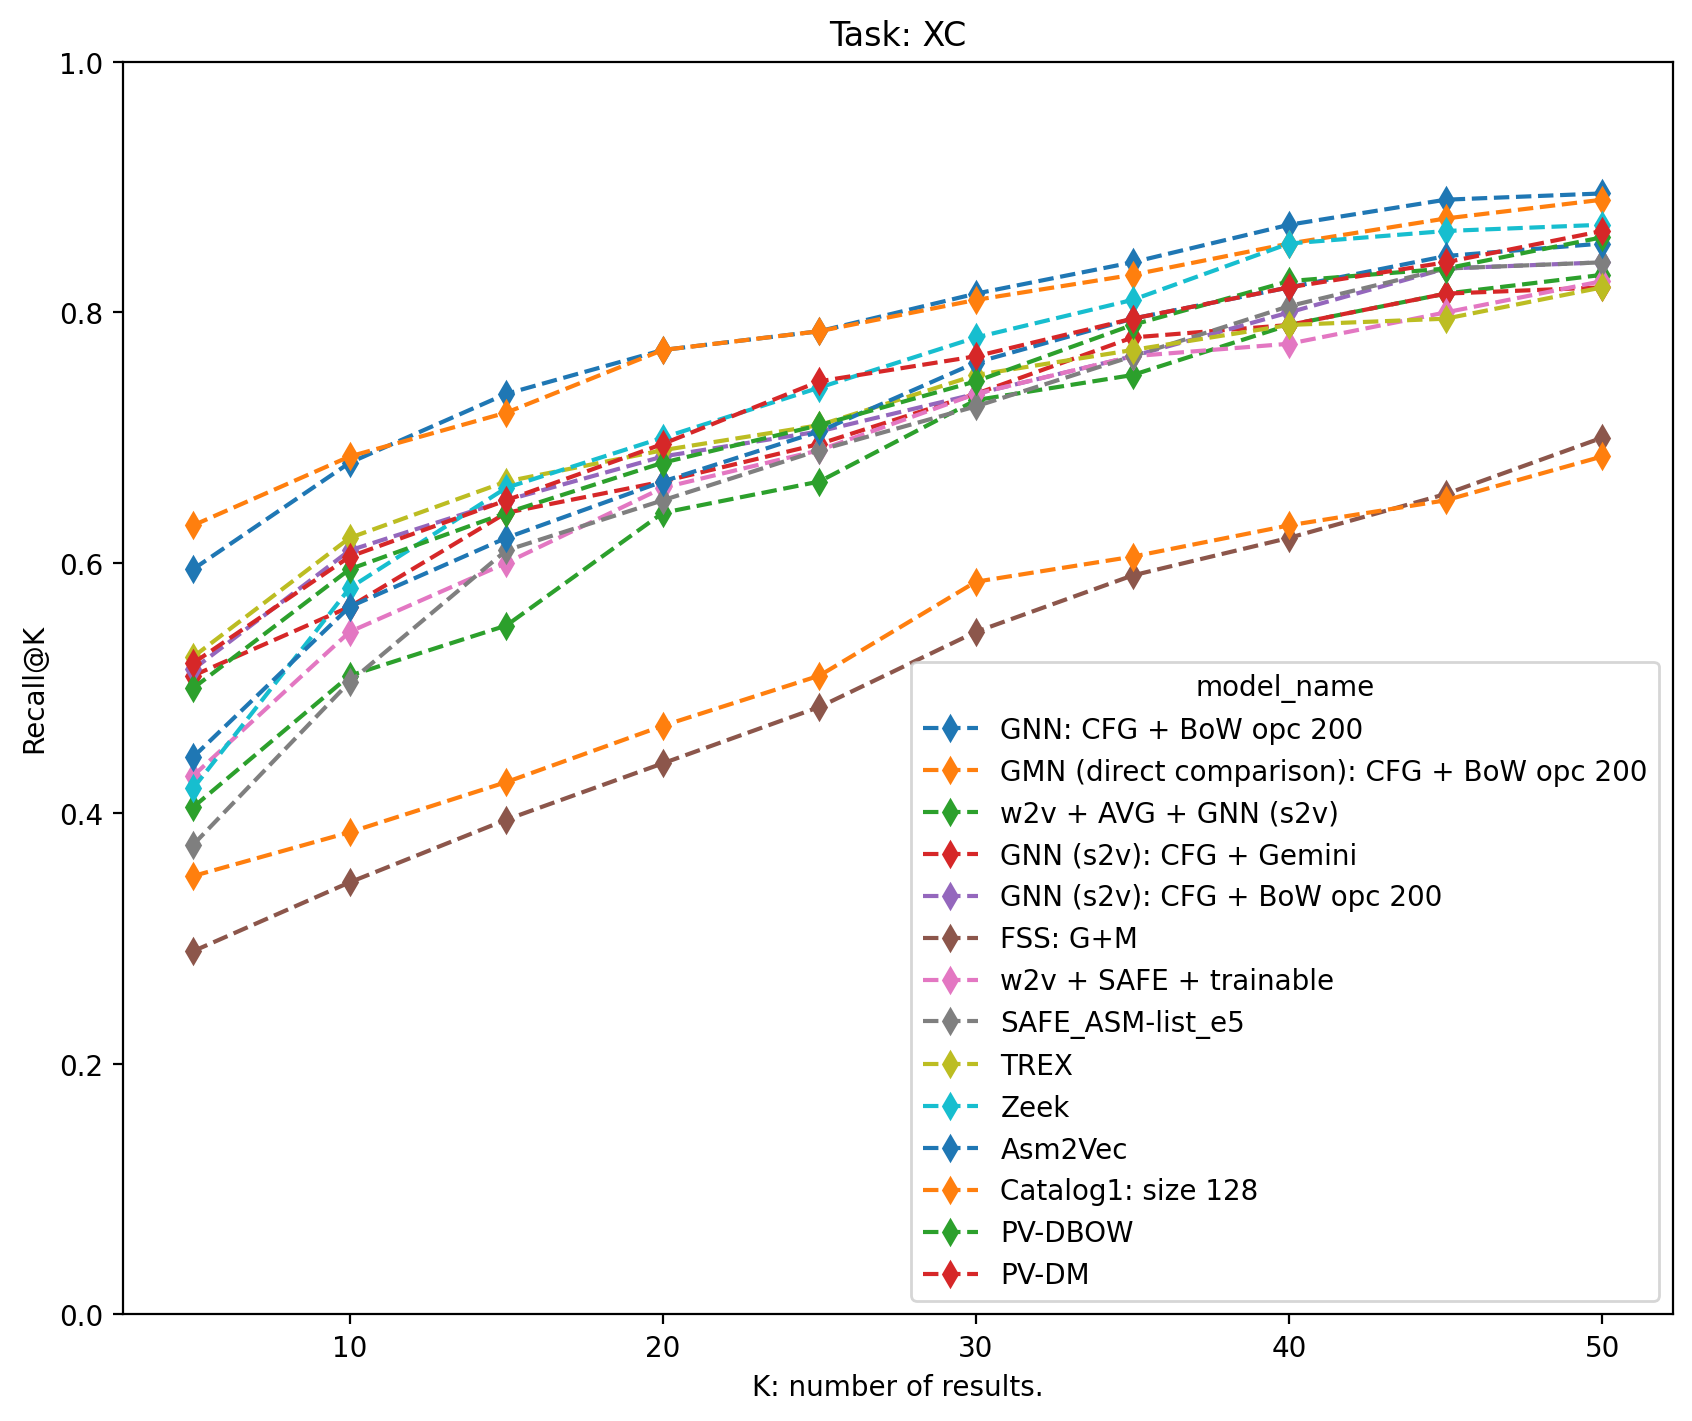

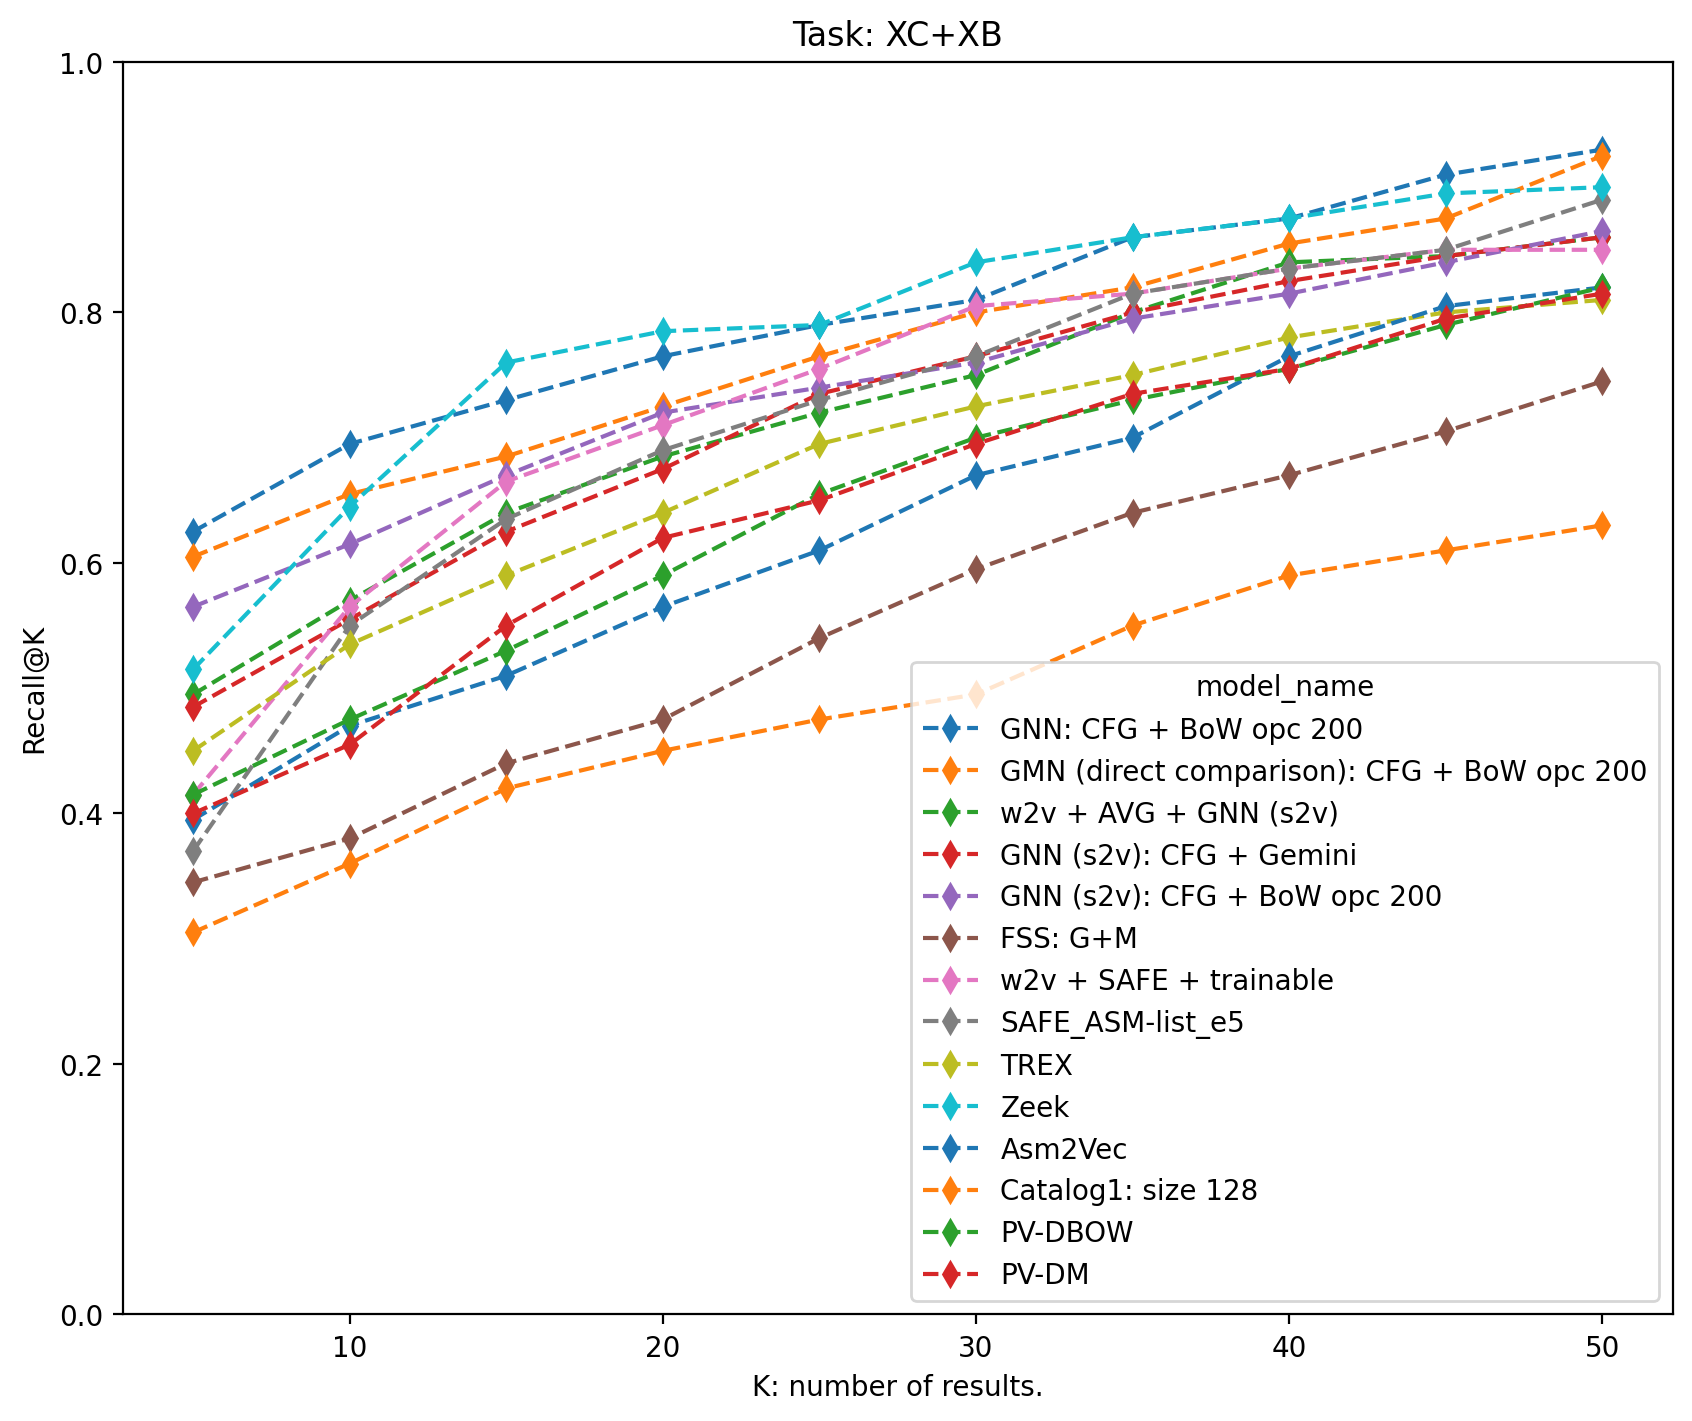

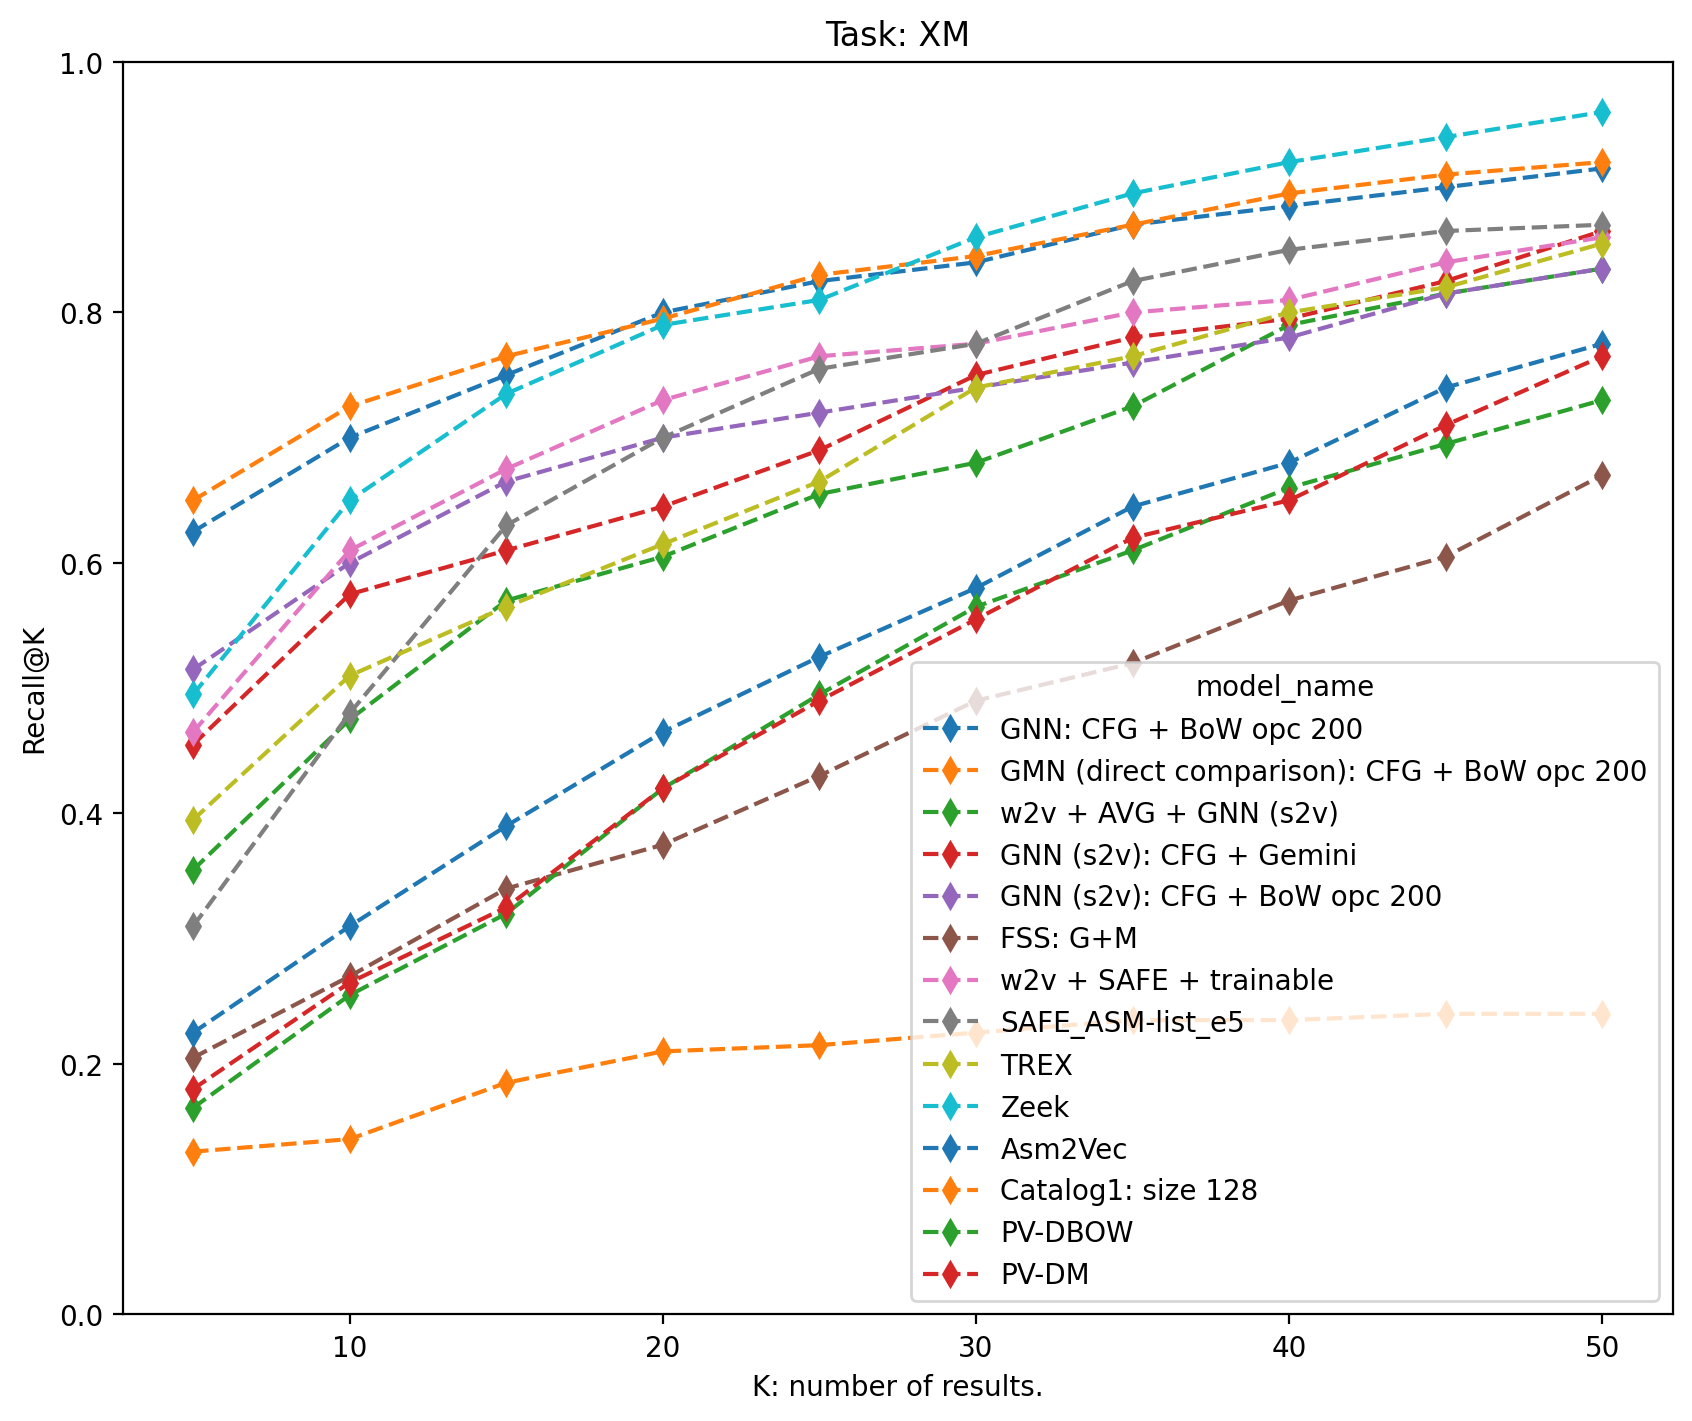

In [10]:
RESULTS_DIR = "../data/Dataset-1/"
OUTPUT_DIR = "metrics_and_plots/Dataset-1/"

base_path = "../../DBs/Dataset-1/pairs/testing/"

df_pos_testing = pd.read_csv(
    os.path.join(base_path, "pos_rank_testing_Dataset-1.csv"),
    index_col=0)

df_neg_testing = pd.read_csv(
    os.path.join(base_path, "neg_rank_testing_Dataset-1.csv"),
    index_col=0)

compute_mrr_and_recall(df_pos_testing, df_neg_testing, RESULTS_DIR, OUTPUT_DIR)

## Dataset 1-CodeCMR

[D] Using rank_method: min
[D] Processing
	pos_rank_testing_Dataset-1-CodeCMR.csv
	pos_rank_testing_Dataset-1-CodeCMR.csv
[D] Processing
	pos_rank_testing_Dataset-1-CodeCMR_GGSNN_IR_200.csv
	pos_rank_testing_Dataset-1-CodeCMR_GGSNN_IR_200.csv
[D] Processing
	pos_rank_testing_Dataset-1-CodeCMR_GGSNN_OPC_200.csv
	pos_rank_testing_Dataset-1-CodeCMR_GGSNN_OPC_200.csv
[D] Task: XA
[D] Task: XC
[D] Task: XC+XB
[D] Task: XM


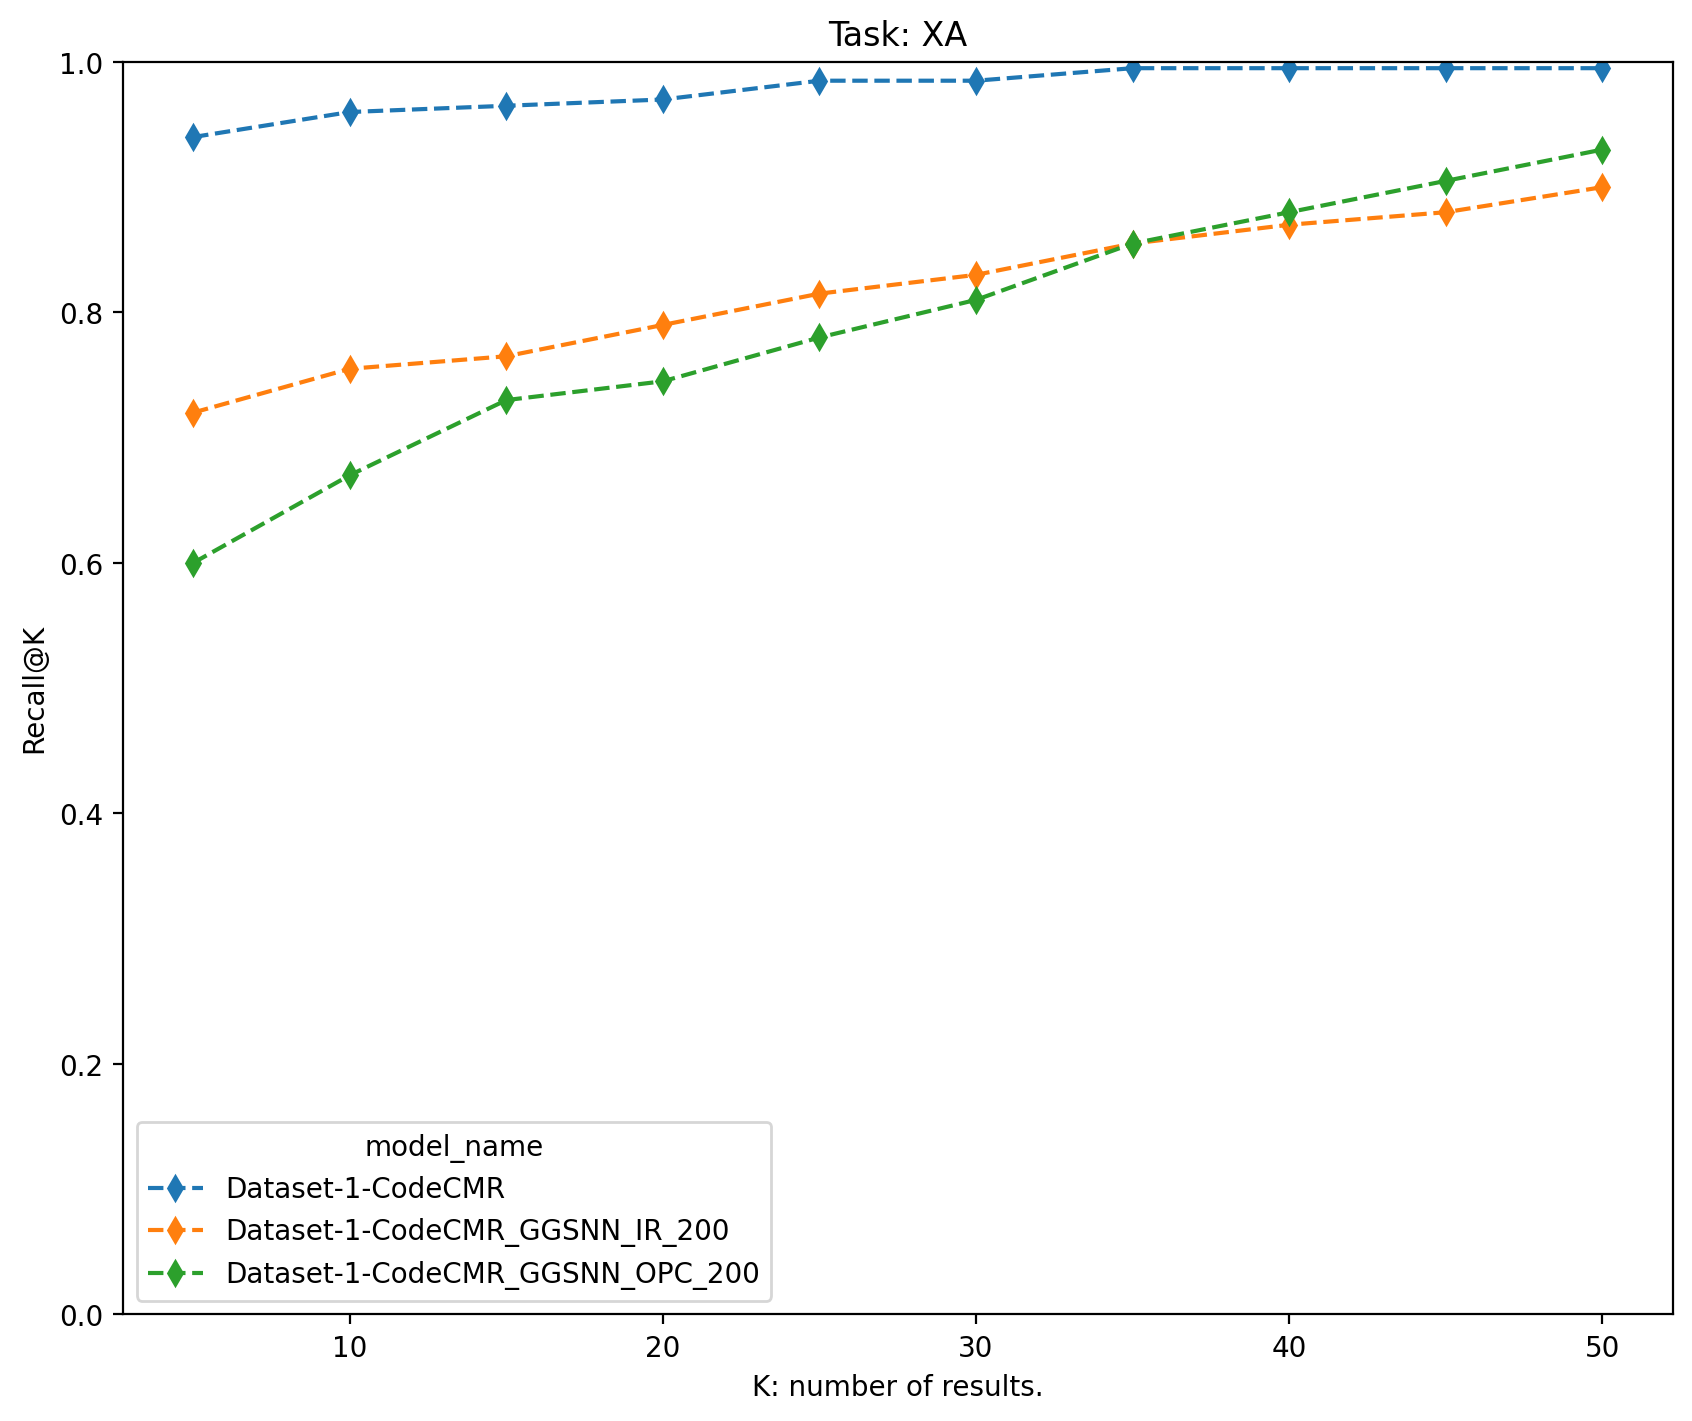

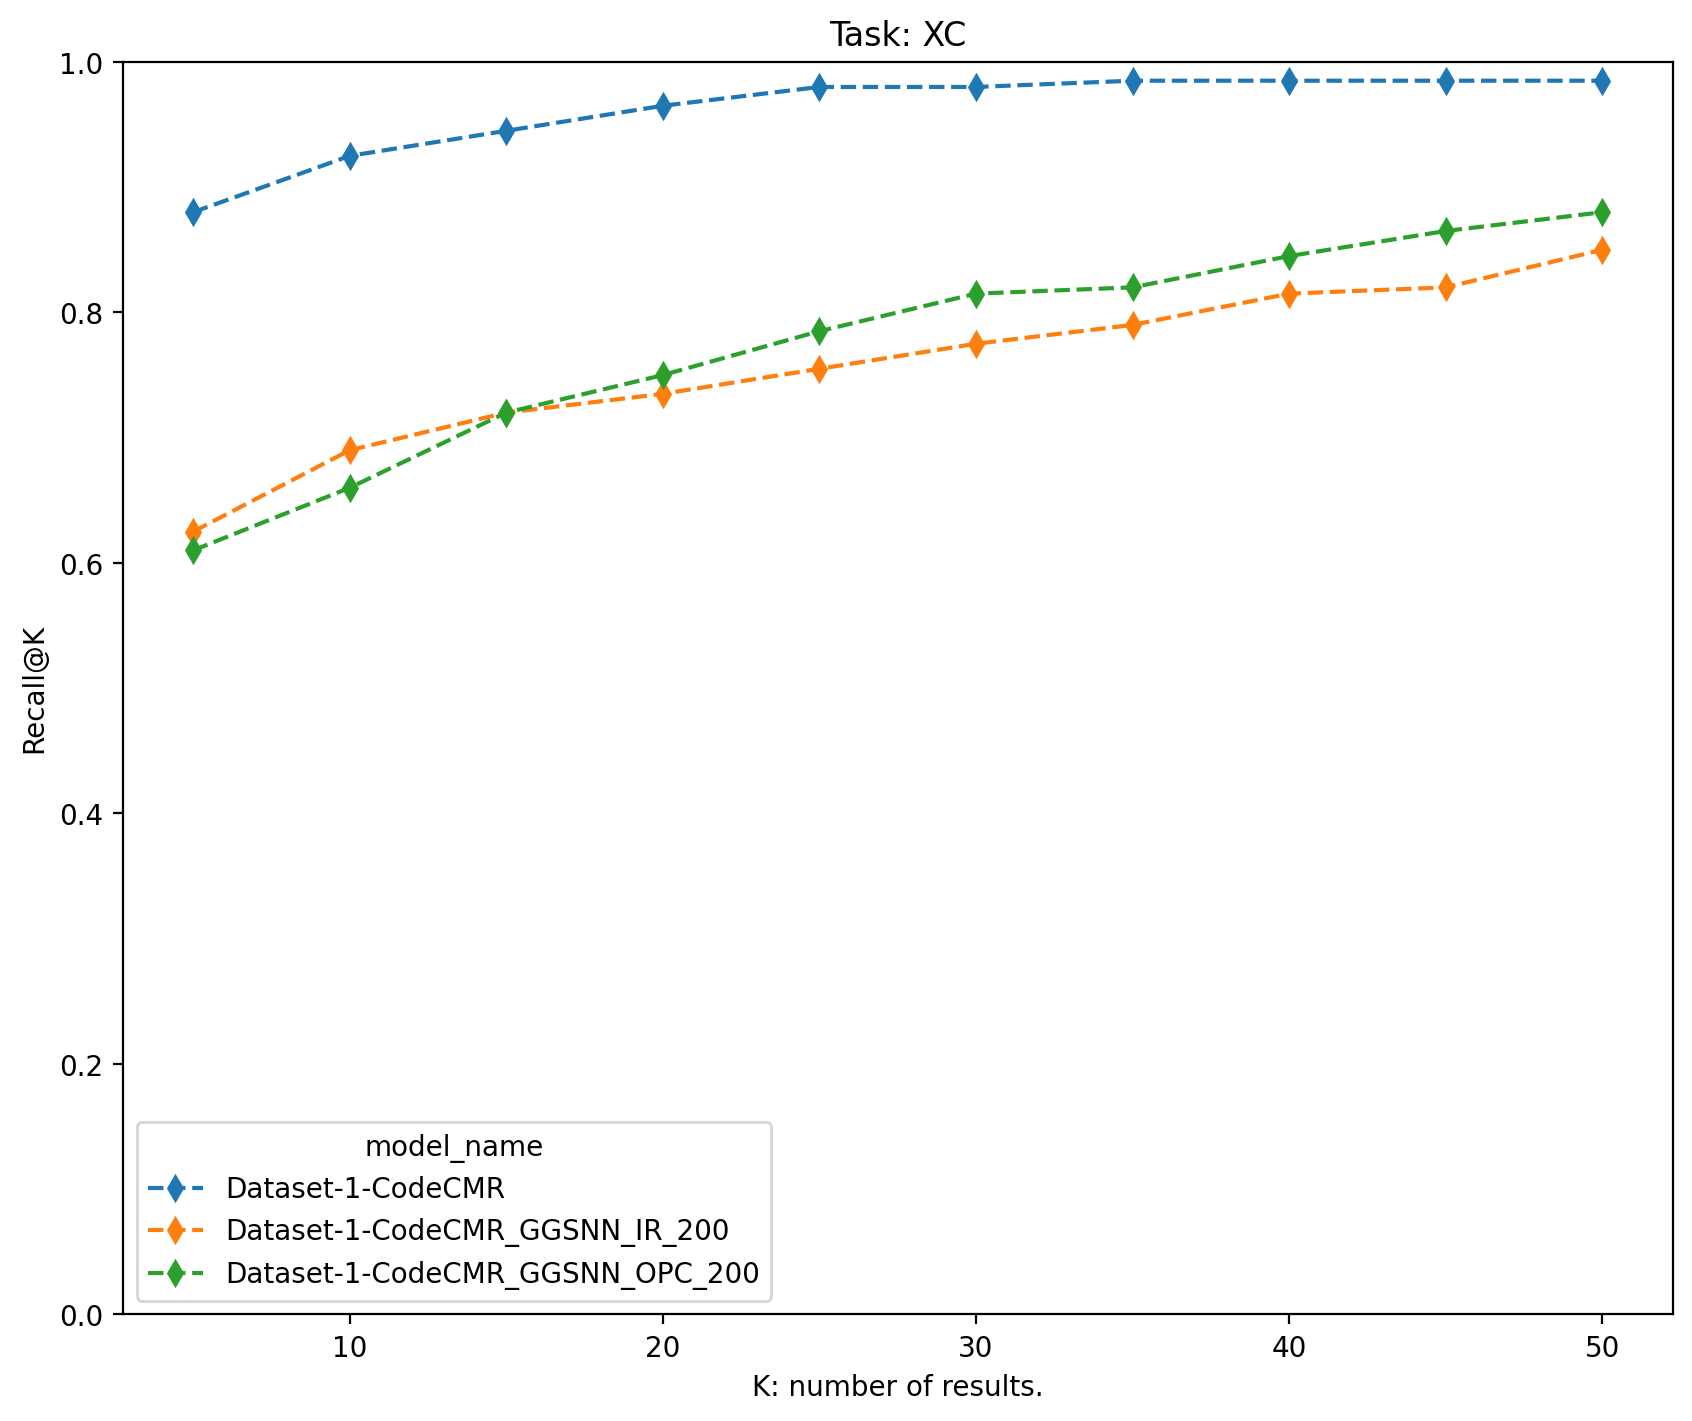

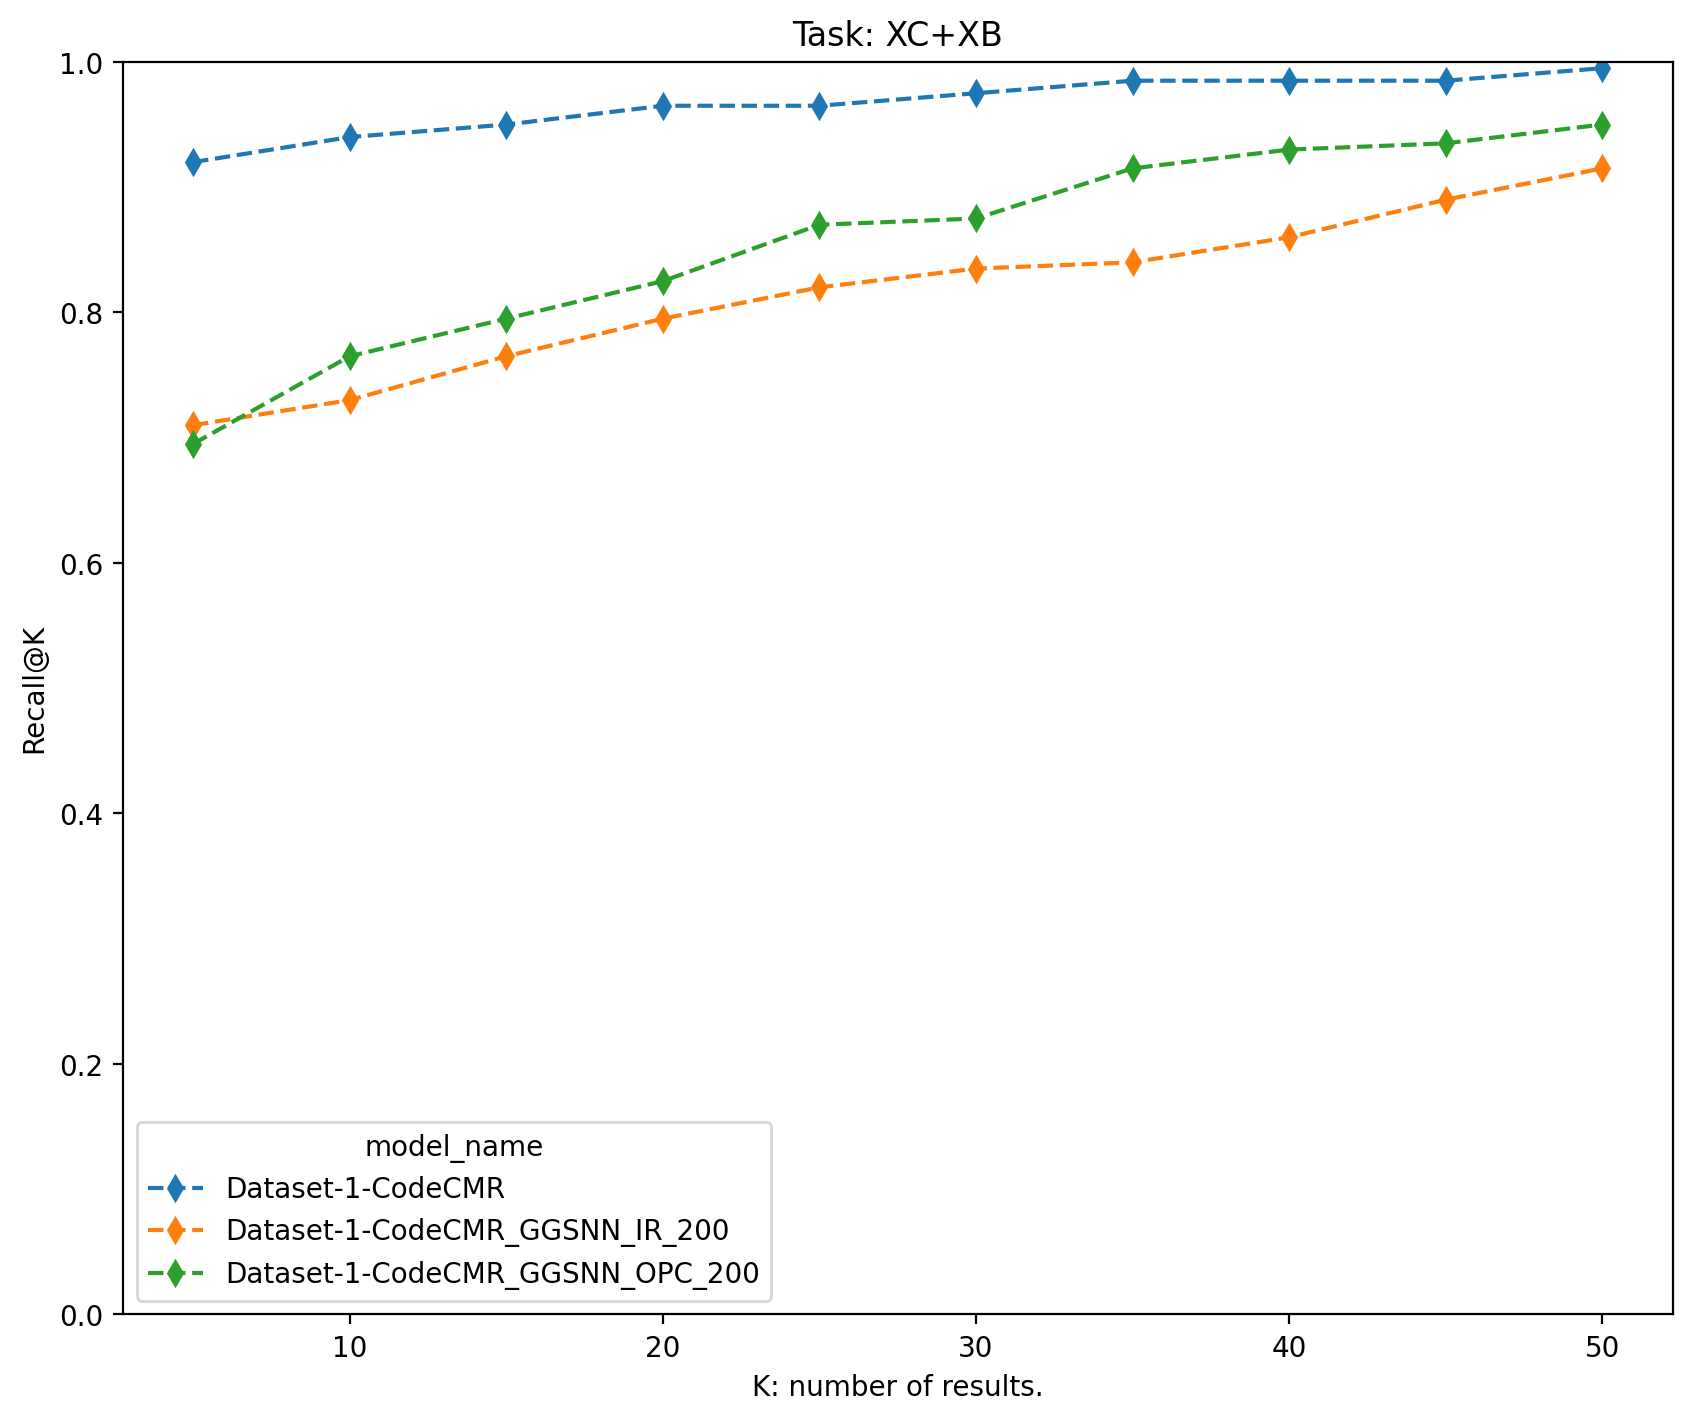

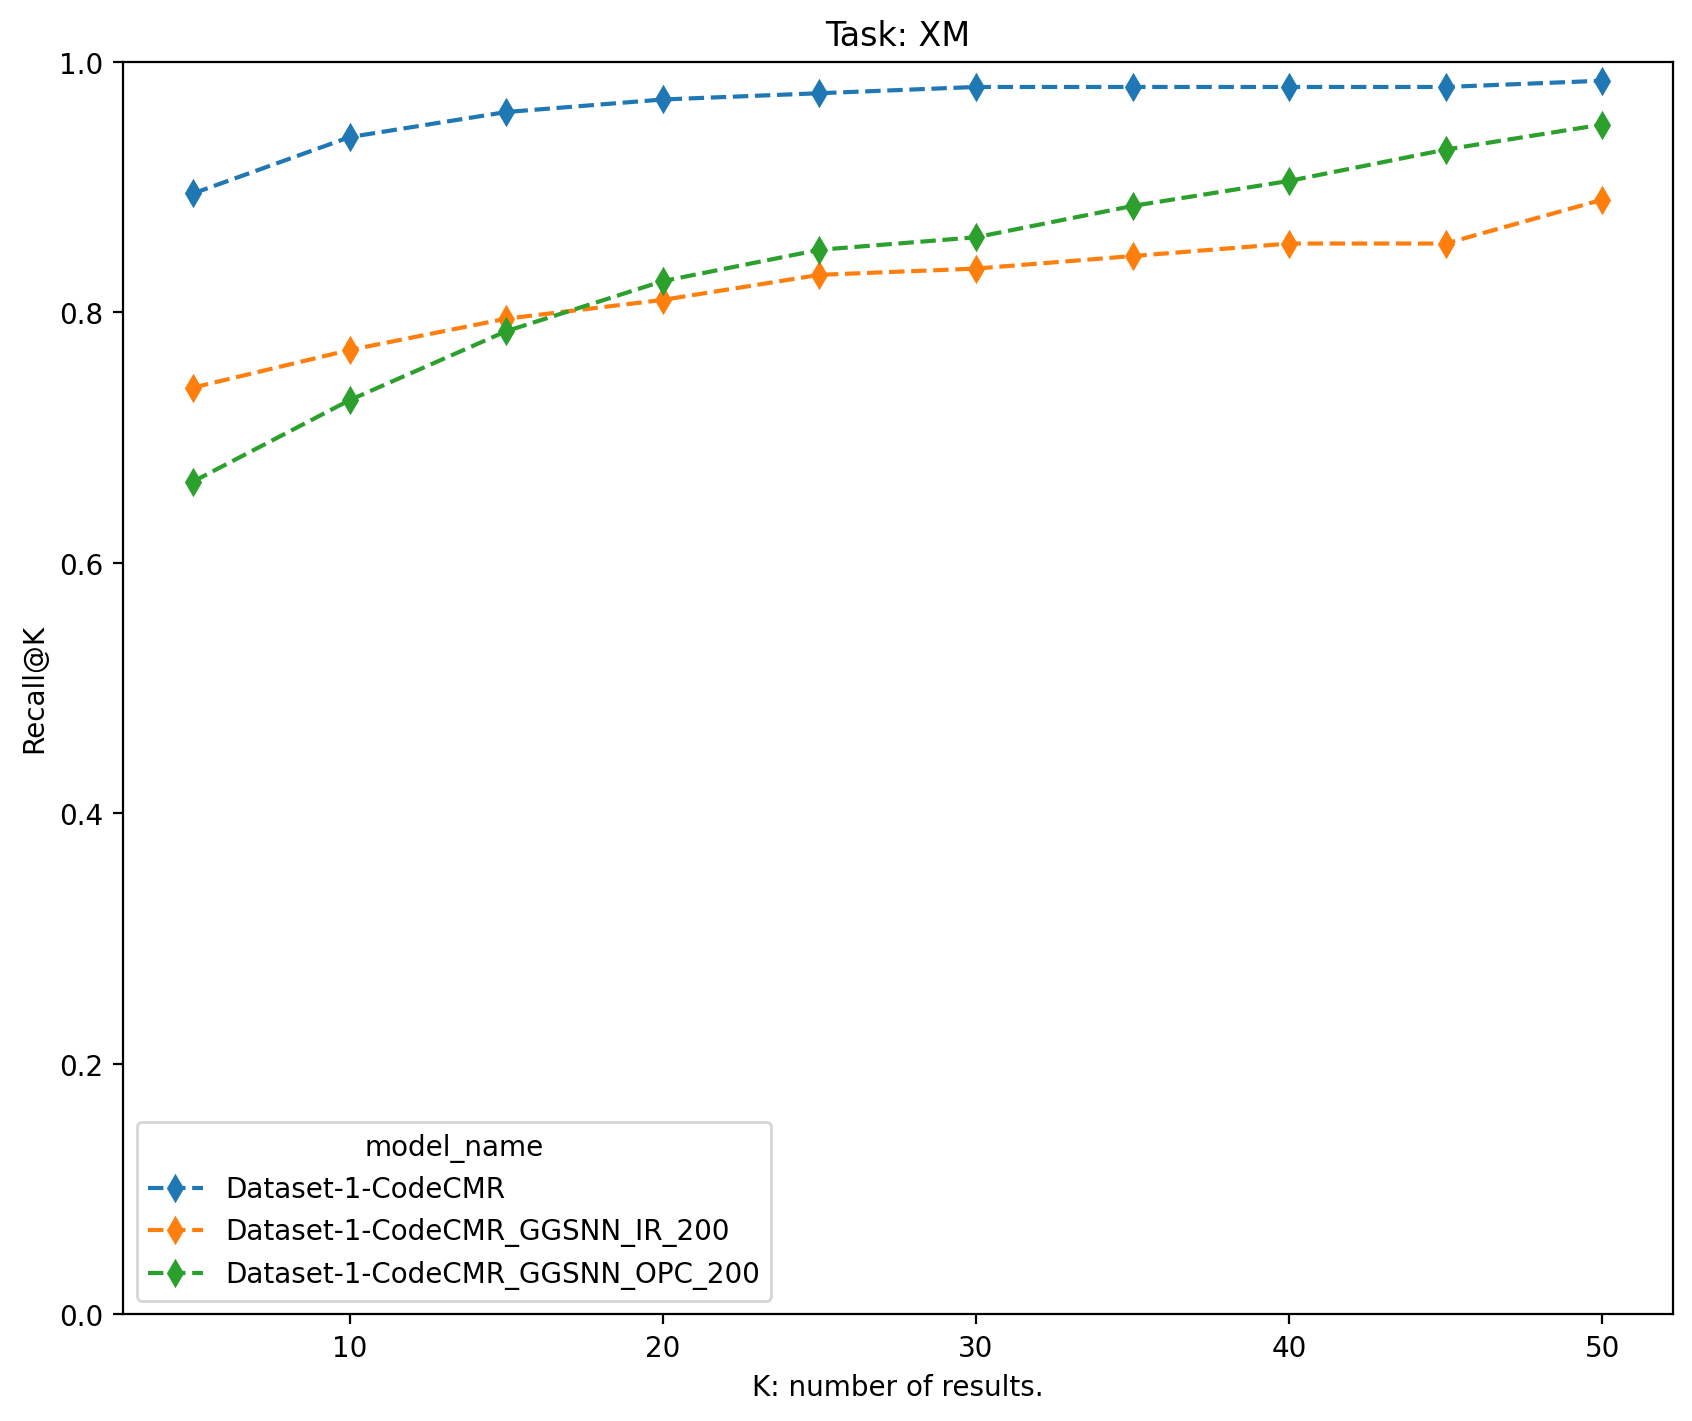

In [11]:
RESULTS_DIR = "../data/Dataset-1-CodeCMR/"
OUTPUT_DIR = "metrics_and_plots/Dataset-1-CodeCMR/"

base_path = "../../DBs/Dataset-1-CodeCMR/pairs/testing/"

df_pos_testing = pd.read_csv(
    os.path.join(base_path, "pos_rank_testing_Dataset-1-CodeCMR.csv"),
    index_col=0)

df_neg_testing = pd.read_csv(
    os.path.join(base_path, "neg_rank_testing_Dataset-1-CodeCMR.csv"),
    index_col=0)

compute_mrr_and_recall(df_pos_testing, df_neg_testing, RESULTS_DIR, OUTPUT_DIR)

## Dataset 2

[D] Using rank_method: min
[D] Processing
	pos_rank_testing_Dataset-2_GGSNN_NoFeatures_e10.csv
	pos_rank_testing_Dataset-2_GGSNN_NoFeatures_e10.csv
[D] Processing
	pos_rank_testing_Dataset-2_GGSNN_OPC-200_e10.csv
	pos_rank_testing_Dataset-2_GGSNN_OPC-200_e10.csv
[D] Processing
	pos_rank_testing_Dataset-2_GMN_NoFeatures_e16.csv
	pos_rank_testing_Dataset-2_GMN_NoFeatures_e16.csv
[D] Processing
	pos_rank_testing_Dataset-2_GMN_OPC-200_e16.csv
	pos_rank_testing_Dataset-2_GMN_OPC-200_e16.csv
[D] Processing
	pos_rank_testing_Dataset-2_GNN-s2v_ArithMean_e5.csv
	pos_rank_testing_Dataset-2_GNN-s2v_ArithMean_e5.csv
[D] Processing
	pos_rank_testing_Dataset-2_GNN-s2v_AttentionMean_e5.csv
	pos_rank_testing_Dataset-2_GNN-s2v_AttentionMean_e5.csv
[D] Processing
	pos_rank_testing_Dataset-2_GNN-s2v_GeminiNN_GeminiFeatures_e5.csv
	pos_rank_testing_Dataset-2_GNN-s2v_GeminiNN_GeminiFeatures_e5.csv
[D] Processing
	pos_rank_testing_Dataset-2_GNN-s2v_GeminiNN_NoFeatures_e5.csv
	pos_rank_testing_Dataset-2_GNN-

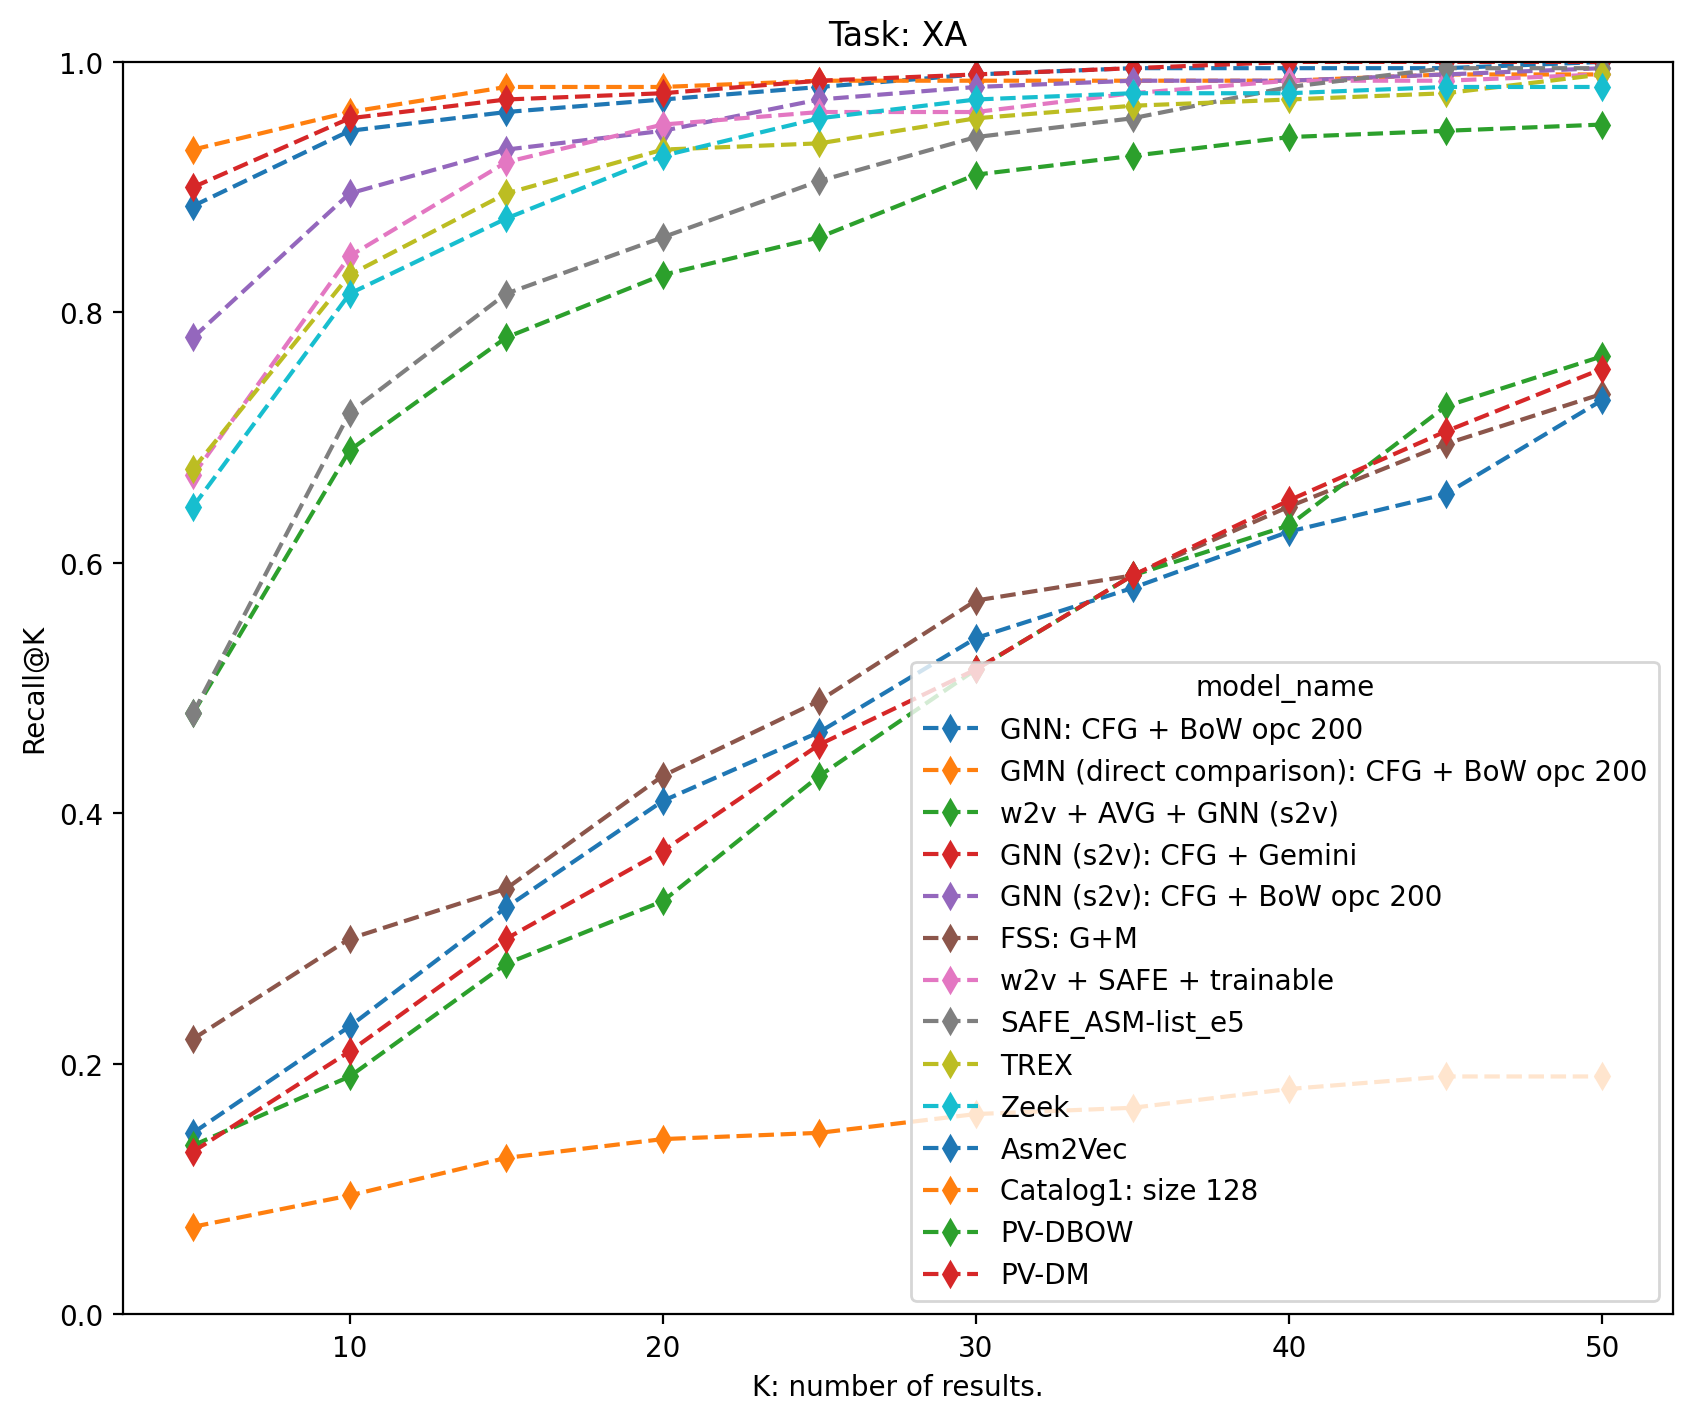

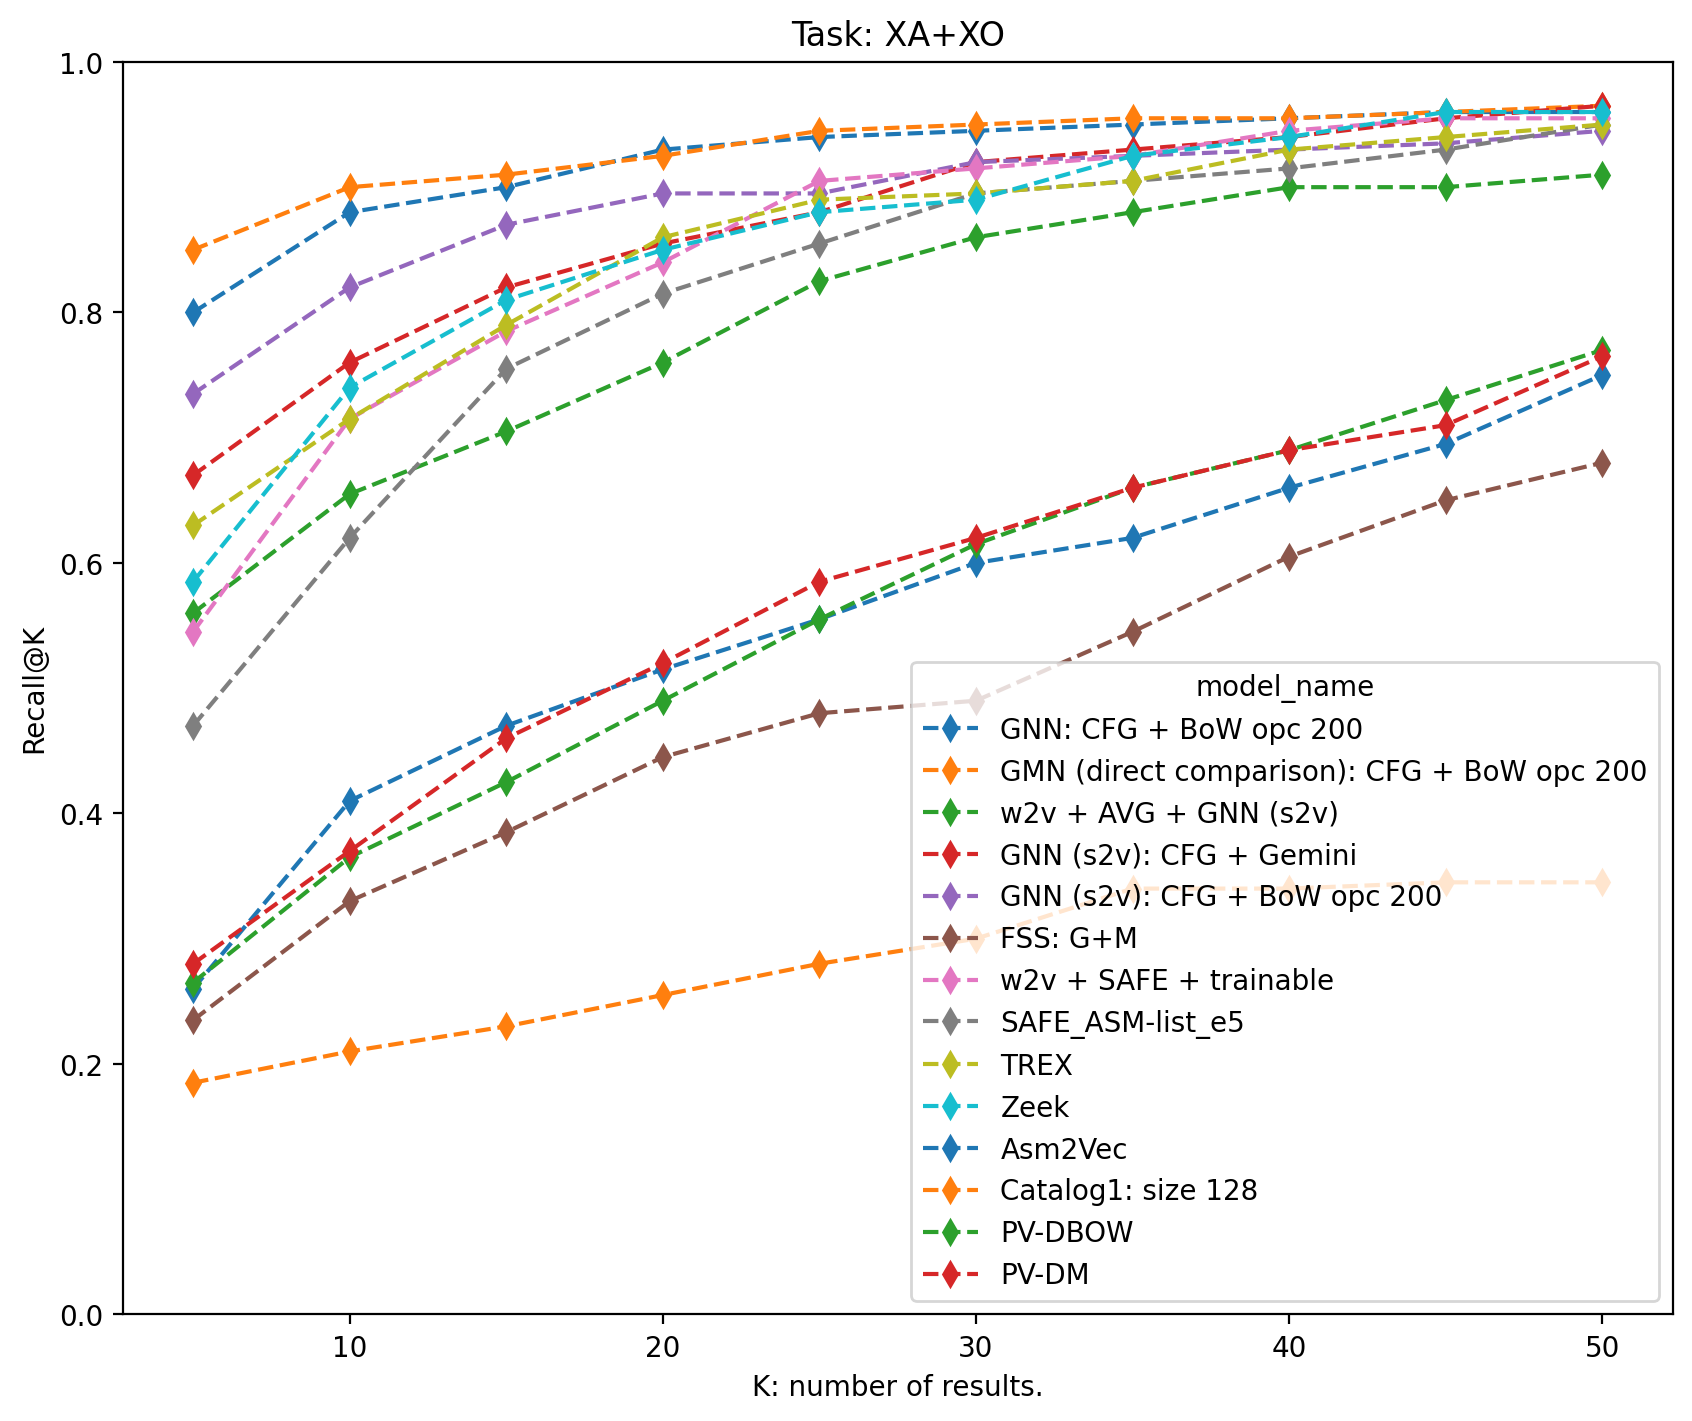

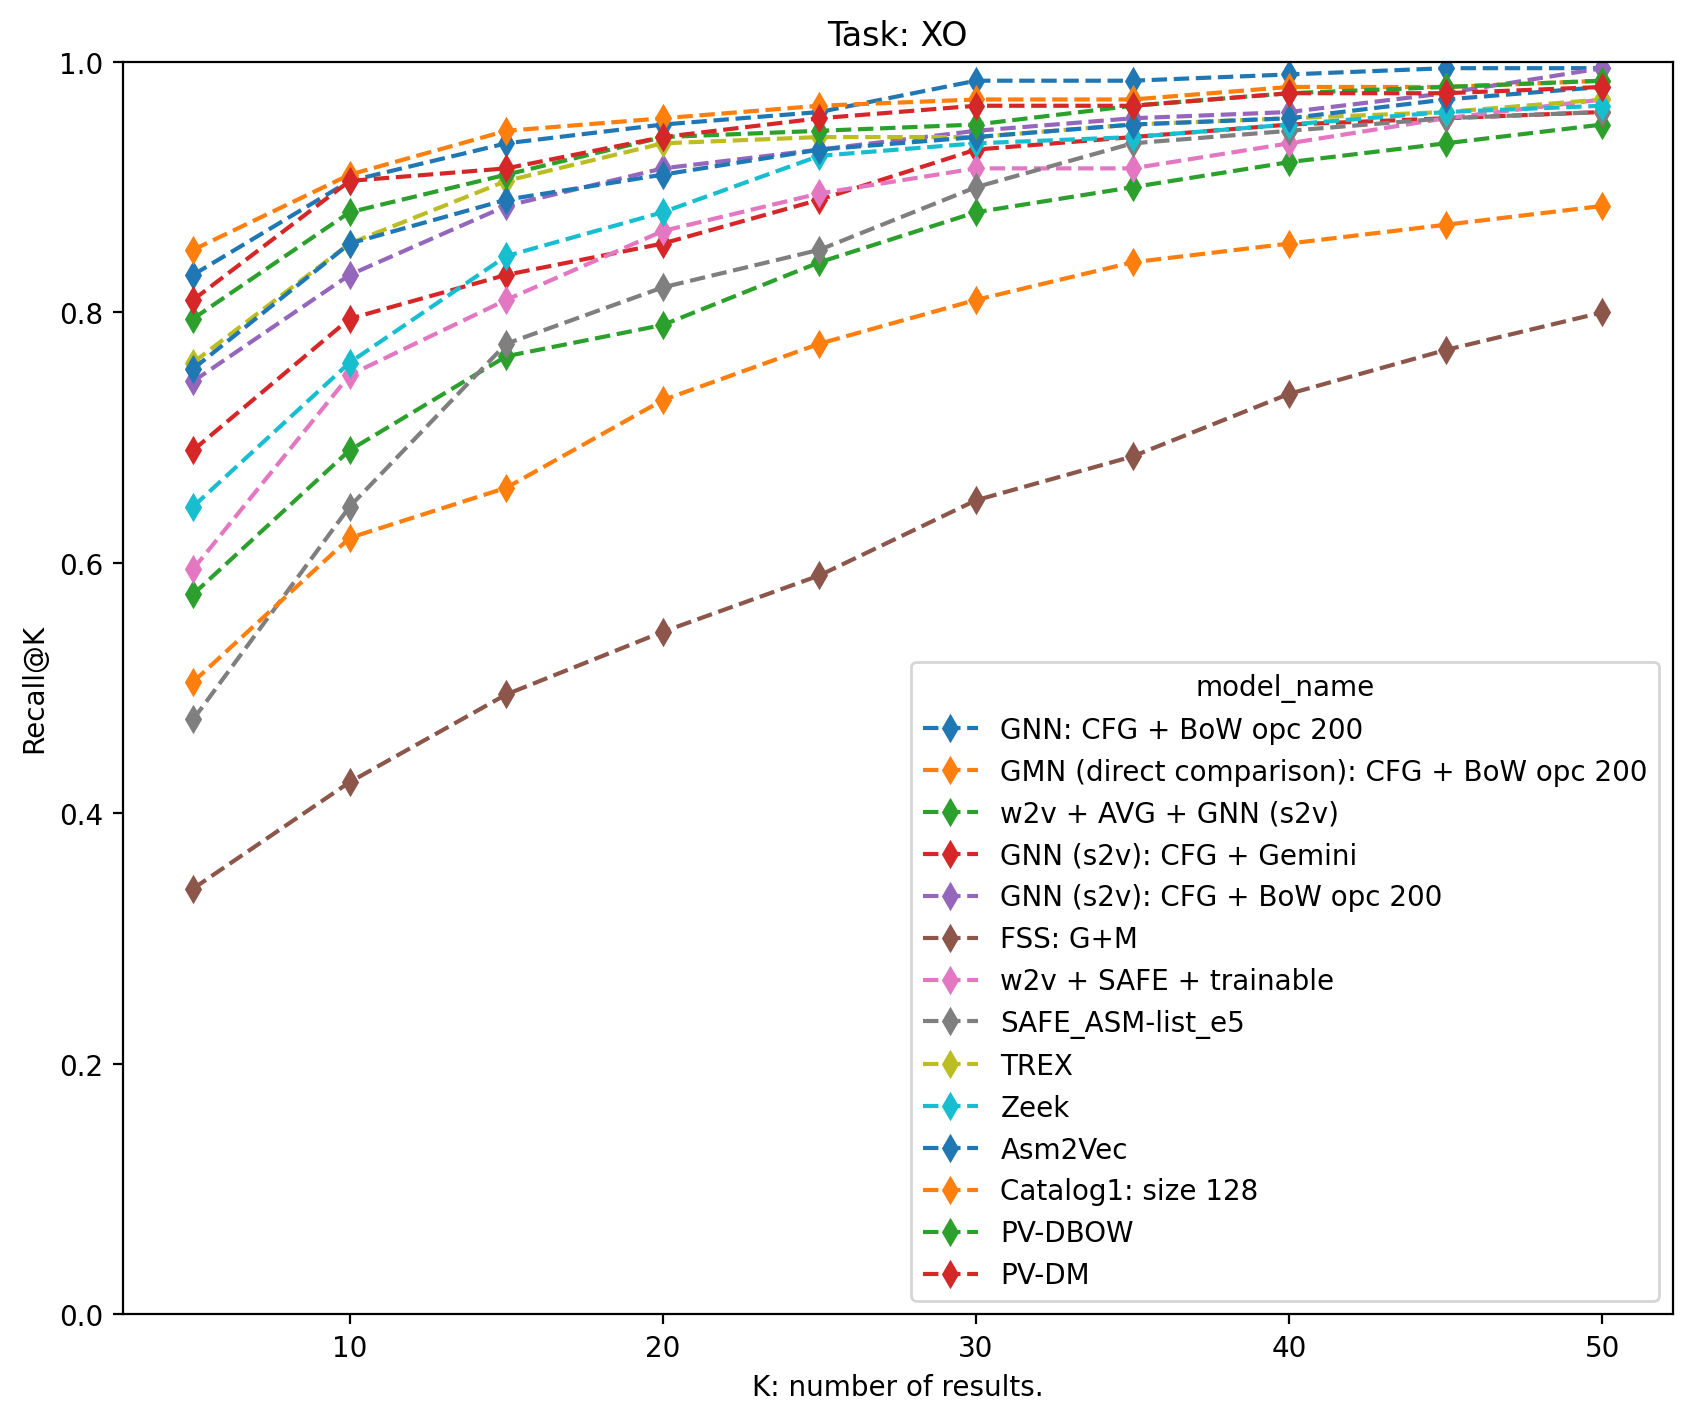

In [12]:
RESULTS_DIR = "../data/Dataset-2/"
OUTPUT_DIR = "metrics_and_plots/Dataset-2/"

base_path = "../../DBs/Dataset-2/pairs/"

df_pos_testing = pd.read_csv(
    os.path.join(base_path, "pos_rank_testing_Dataset-2.csv"),
    index_col=0)

df_neg_testing = pd.read_csv(
    os.path.join(base_path, "neg_rank_testing_Dataset-2.csv"),
    index_col=0)

compute_mrr_and_recall(df_pos_testing, df_neg_testing, RESULTS_DIR, OUTPUT_DIR)